In [ ]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import matplotlib

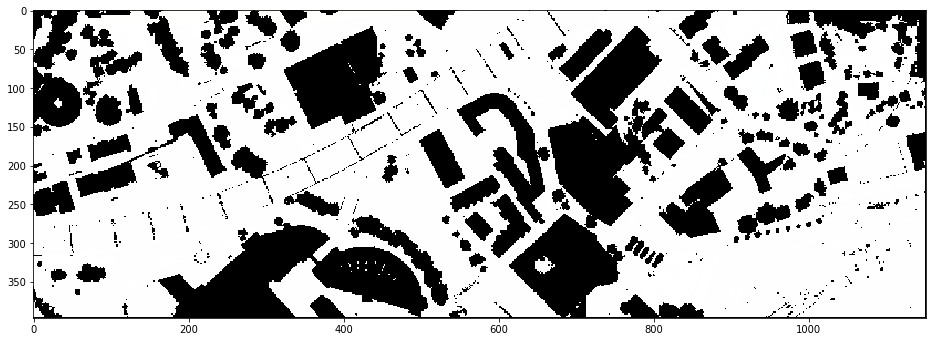

In [2]:
image = envi.open('../../../hyperImage/radiance/SWIR/training_image_swir.hdr', 
                  '../../../hyperImage/radiance/SWIR/training_image_swir.')
img = image.load()
view = imshow(img, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)), figsize=(16, 16))

In [3]:
image.shape

(397, 1152, 20)

In [4]:
pc_img = img[:,:, :3]
pc_img.shape

(397, 1152, 3)

In [5]:
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
main_df = pd.concat([df_pca], axis=1, sort=False)

In [6]:
## Class image
gt_data = Image.open('../../../hyperImage/radiance/SWIR/class.tif')
gt = np.array(gt_data)
gt.shape

(397, 1152)

In [7]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [8]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

# Using only hyperspectral data 

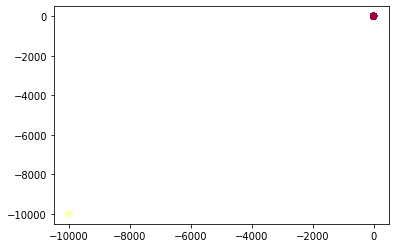

In [9]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

In [10]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [12]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=2, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.8566084788029925

In [13]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.70      1.00      0.82       789
           2       1.00      1.00      1.00       324
           3       1.00      1.00      1.00       546
           4       1.00      1.00      1.00       334
           5       0.99      0.17      0.29       413

    accuracy                           0.86      2406
   macro avg       0.94      0.83      0.82      2406
weighted avg       0.90      0.86      0.82      2406



In [14]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=2, n_jobs= -1)
random_forest.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [15]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [16]:
y_pred = random_forest.predict(X_data_scaled)

In [17]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

In [18]:
road = (predicted_hsi_mask == 1).astype(int)

In [19]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.035636451095342636]
    G: [-9999.0, 0.006073268596082926]
    B: [-9999.0, 0.0001774278498487547]
>

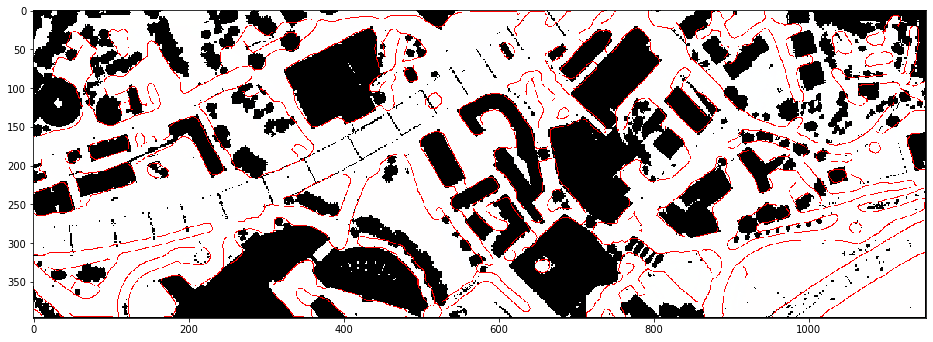

In [20]:
view = imshow(image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.035636451095342636]
    G: [-9999.0, 0.006073268596082926]
    B: [-9999.0, 0.0001774278498487547]
>

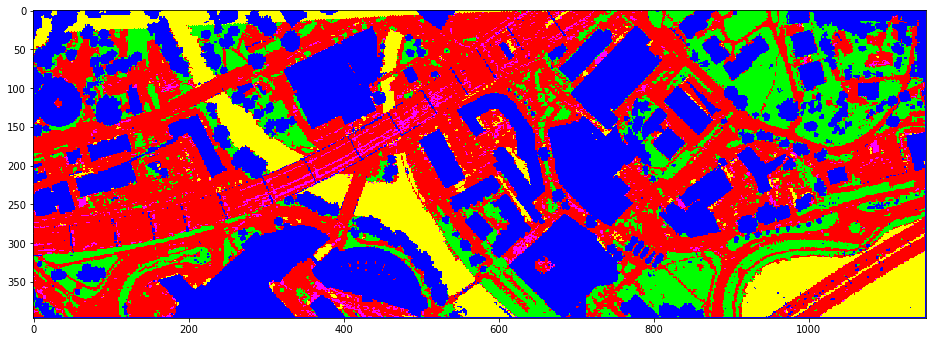

In [21]:
view = imshow(image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [22]:
val_image = envi.open('../../../hyperImage/radiance/SWIR/validation/swir_vali_image.hdr', '../../../hyperImage/radiance/SWIR/validation/swir_vali_image.')
val_img = val_image.load()
val_img.shape

(314, 1817, 20)

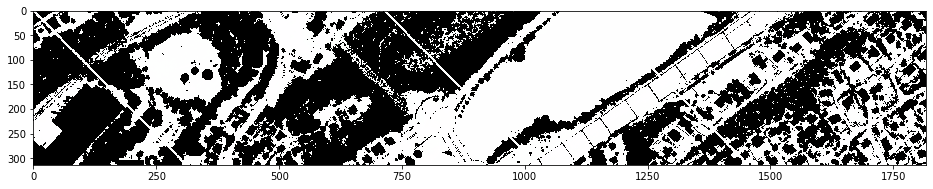

In [23]:
view = imshow(val_image, (3, 2, 1), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [24]:
#pc_img = val_img_pc.load()
pc_img = val_img[:,:, :3]
pc_img.shape

(314, 1817, 3)

In [25]:
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
main_df_val = pd.concat([df_pca], axis=1, sort=False)

In [26]:
main_df_val_scaled = scaler.transform(main_df_val)
hsi_val_pred = random_forest.predict(main_df_val_scaled)
predicted_hsi_mask_val = hsi_val_pred.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.012547774240374565]
    G: [-9999.0, 0.0010637505911290646]
    B: [-9999.0, 0.0010241272393614054]
>

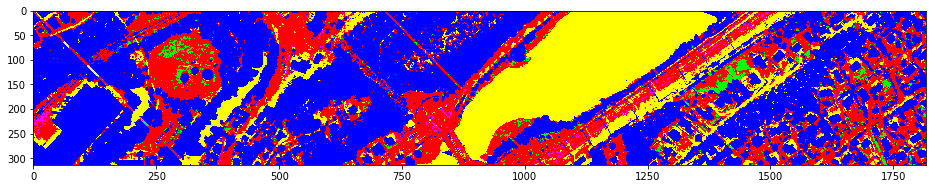

In [27]:
#val_full_image = envi.open('../../hyperImage/reflectance/swir/08_cliped.hdr', '../../hyperImage/reflectance/swir/08_cliped.')
view = imshow(val_image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [28]:
## Class image
gt_data_val = Image.open('../../../hyperImage/radiance/SWIR/validation/class_val.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(314, 1817)

In [29]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(570538, 1)

In [30]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [31]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values
X_data_scaled_val = scaler.transform(X_val)
y_pred = random_forest.predict(X_data_scaled_val)

In [32]:
accuracy_score(y_val, y_pred)

0.7048992272763482

In [33]:
target_names = ['Road', 'Vegetation', 'Unclassified','Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.29      0.89      0.43      7094
  Vegetation       1.00      0.18      0.30     10329
Unclassified       0.95      0.99      0.97      8642
       Water       0.93      1.00      0.96     26575
 Train Track       0.75      0.10      0.17     10125

    accuracy                           0.70     62765
   macro avg       0.78      0.63      0.57     62765
weighted avg       0.84      0.70      0.67     62765



In [34]:
cohen_kappa_score(y_val, y_pred)

0.601140435290943

In [35]:
confusion_matrix(y_val, y_pred)

array([[ 6342,     5,    56,   372,   319],
       [ 8471,  1849,     9,     0,     0],
       [    0,     0,  8536,   106,     0],
       [    0,     0,    22, 26553,     0],
       [ 7314,     0,   350,  1498,   963]])

# Using Lidar Data Only

In [36]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../../hyperImage/radiance/SWIR/training_intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../../hyperImage/radiance/SWIR/training_nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [37]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0).all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [38]:
df_lidar

,Lidar Intensity,Lidar nDSM,Target
0,-9999.0,-9999.00,0
1,-9999.0,-9999.00,0
2,-9999.0,-9999.00,0
3,-9999.0,-9999.00,0
4,-9999.0,-9999.00,0
...,...,...,...
457339,7.0,0.06,0
457340,24.0,0.03,0
457341,9.0,0.02,0
457342,8.0,0.02,0


In [39]:
scaler1 = MinMaxScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [41]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest2.fit(X_train, y_train)
pred = random_forest2.predict(X_test)
accuracy_score(y_test, pred)

0.7946799667497921

In [42]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [43]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = random_forest3.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(l_intensity.shape[0], l_intensity.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.035636451095342636]
    G: [-9999.0, 0.006073268596082926]
    B: [-9999.0, 0.0001774278498487547]
>

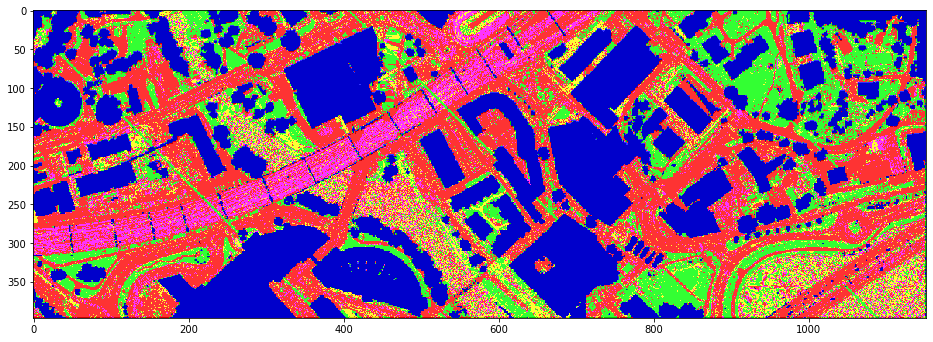

In [44]:
view = imshow(image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.8
view.show_data

In [45]:
road = (predicted_lidar_mask == 1).astype(int)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.035636451095342636]
    G: [-9999.0, 0.006073268596082926]
    B: [-9999.0, 0.0001774278498487547]
>

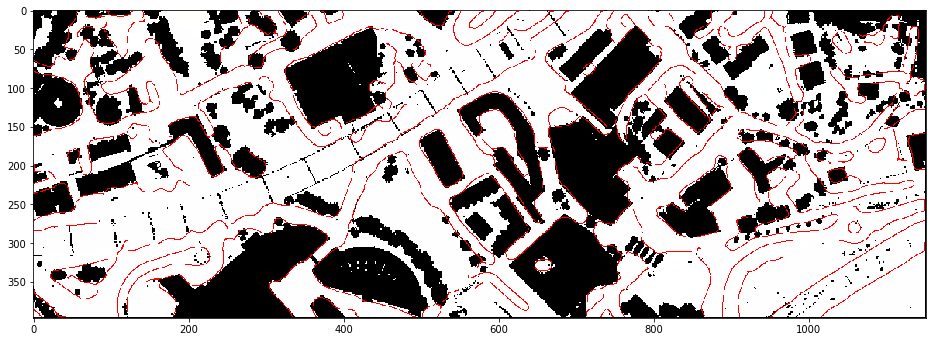

In [47]:
view = imshow(image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [48]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../../hyperImage/radiance/SWIR/validation/validation_intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity_val = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity_val.columns = [string]

l_dsm_data = Image.open('../../../hyperImage/radiance/SWIR/validation/validation_nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm_val = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm_val.columns = [string]

In [49]:
l_dsm.shape

(314, 1817)

In [50]:
df_lidar_val = pd.concat([df_intensity_val, df_dsm_val], axis=1, sort=False)
df_lidar_val

,Lidar Intensity,Lidar nDSM
0,14.0,0.000000
1,19.0,0.000000
2,-9999.0,-9999.000000
3,-9999.0,-9999.000000
4,-9999.0,-9999.000000
...,...,...
570533,3.0,0.020000
570534,3.0,0.060001
570535,3.0,0.850002
570536,2.0,0.299999


In [51]:
X_data_scaled = scaler1.transform(df_lidar_val)
val_pred_full = random_forest3.predict(X_data_scaled)
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.012547774240374565]
    G: [-9999.0, 0.0010637505911290646]
    B: [-9999.0, 0.0010241272393614054]
>

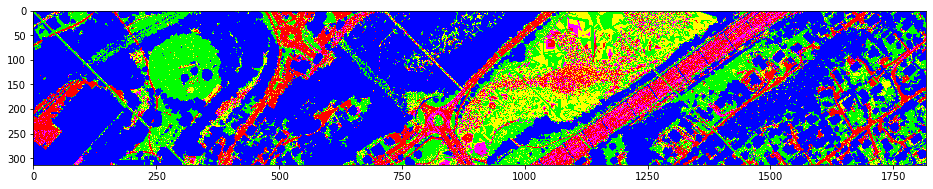

In [52]:
view = imshow(val_image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [53]:
df_lidar_val = pd.concat([df_lidar_val, df_class_val], axis=1, sort=False)
df_lidar_val

,Lidar Intensity,Lidar nDSM,Target
0,14.0,0.000000,0
1,19.0,0.000000,0
2,-9999.0,-9999.000000,0
3,-9999.0,-9999.000000,0
4,-9999.0,-9999.000000,0
...,...,...,...
570533,3.0,0.020000,0
570534,3.0,0.060001,0
570535,3.0,0.850002,0
570536,2.0,0.299999,0


In [54]:
df_lidar_val_masked = df_lidar_val[(df_lidar_val[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [55]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = random_forest3.predict(X_data_scaled_val)

In [56]:
accuracy_score(y_val, y_pred)

0.6036803951246714

In [57]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.37      0.80      0.50      7094
  Vegetation       0.52      0.94      0.66     10329
Unclassified       0.94      0.98      0.96      8642
       Water       0.89      0.40      0.56     26575
 Train Track       0.45      0.32      0.38     10125

    accuracy                           0.60     62765
   macro avg       0.63      0.69      0.61     62765
weighted avg       0.70      0.60      0.59     62765



In [58]:
confusion_matrix(y_val, y_pred)

array([[ 5689,   156,    88,   321,   840],
       [   37,  9668,    18,   580,    26],
       [  107,    15,  8503,    10,     7],
       [ 3972,  8610,    26, 10746,  3221],
       [ 5754,   307,   363,   417,  3284]])

In [59]:
cohen_kappa_score(y_val, y_pred)

0.5062382307455218

# Using  hyperspectral and lidar data 

# Training

In [60]:
df_lid_hsi = pd.concat([main_df,df_lidar], axis=1, sort=False)

In [61]:
df_lid_hsi

,PC1,PC2,PC3,Lidar Intensity,Lidar nDSM,Target
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00,0
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00,0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00,0
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00,0
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00,0
...,...,...,...,...,...,...
457339,-9999.0,-9999.0,-9999.0,7.0,0.06,0
457340,-9999.0,-9999.0,-9999.0,24.0,0.03,0
457341,-9999.0,-9999.0,-9999.0,9.0,0.02,0
457342,-9999.0,-9999.0,-9999.0,8.0,0.02,0


In [62]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0).all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [63]:
scaler3 = MinMaxScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.9372402327514547

In [65]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [66]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [67]:
y_pred = random_forest3.predict(X_data_scaled)
predicted_hsi_lidar_mask = y_pred.reshape(image.shape[0], image.shape[1])

In [68]:
road = (predicted_hsi_lidar_mask == 1).astype(int)
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.035636451095342636]
    G: [-9999.0, 0.006073268596082926]
    B: [-9999.0, 0.0001774278498487547]
>

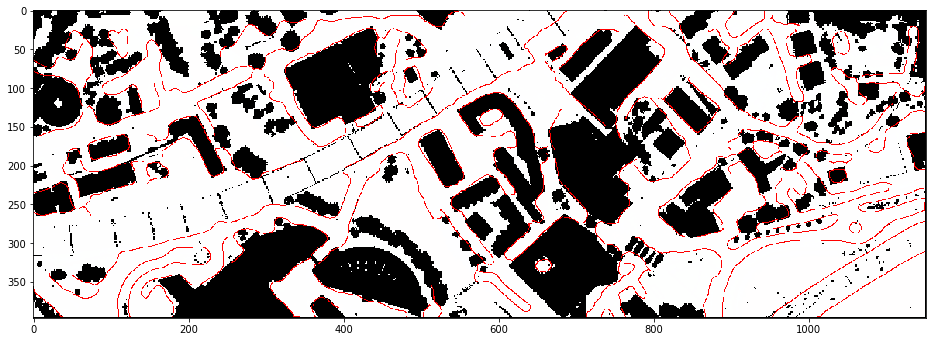

In [69]:
view = imshow(image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.035636451095342636]
    G: [-9999.0, 0.006073268596082926]
    B: [-9999.0, 0.0001774278498487547]
>

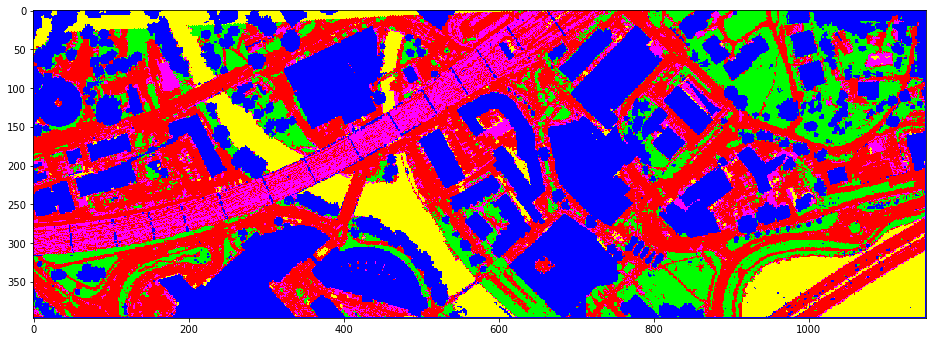

In [70]:
view = imshow(image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation data

In [71]:
df_lid_hsi_val = pd.concat([main_df_val, df_lidar_val], axis=1, sort=False)
df_lid_hsi_val

,PC1,PC2,PC3,Lidar Intensity,Lidar nDSM,Target
0,-0.068879,0.009195,-0.003230,14.0,0.000000,0
1,-0.066509,0.010763,-0.003229,19.0,0.000000,0
2,-0.066509,0.010763,-0.003229,-9999.0,-9999.000000,0
3,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0
4,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0
...,...,...,...,...,...,...
570533,-9999.000000,-9999.000000,-9999.000000,3.0,0.020000,0
570534,-9999.000000,-9999.000000,-9999.000000,3.0,0.060001,0
570535,-9999.000000,-9999.000000,-9999.000000,3.0,0.850002,0
570536,-9999.000000,-9999.000000,-9999.000000,2.0,0.299999,0


In [72]:
df_lid_hsi_val = df_lid_hsi_val.drop(columns = 'Target')

In [73]:
X_data_scaled = scaler3.transform(df_lid_hsi_val)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (2, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.0010637505911290646]
    G: [-9999.0, 0.0010637505911290646]
    B: [-9999.0, 0.0010241272393614054]
>

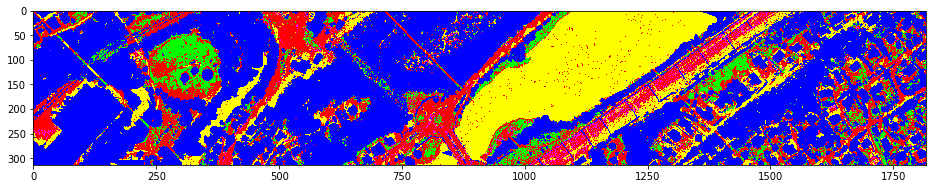

In [74]:
val_pred_full = random_forest3.predict(X_data_scaled)
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])
view = imshow(val_image, (2, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [75]:
road = (predicted_hsi_lidar_mask_val == 1).astype(int)

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (1, 2, 3)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-9999.0, 0.012547774240374565]
    G: [-9999.0, 0.0010637505911290646]
    B: [-9999.0, 0.0010241272393614054]
>

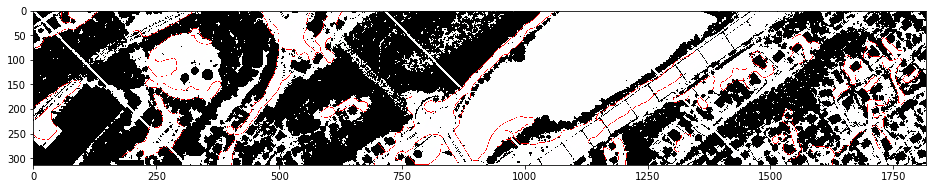

In [77]:
view = imshow(val_image, (1, 2, 3), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [78]:
df_val = pd.concat([df_lid_hsi_val, df_class_val], axis=1, sort=False)
df_val

,PC1,PC2,PC3,Lidar Intensity,Lidar nDSM,Target
0,-0.068879,0.009195,-0.003230,14.0,0.000000,0
1,-0.066509,0.010763,-0.003229,19.0,0.000000,0
2,-0.066509,0.010763,-0.003229,-9999.0,-9999.000000,0
3,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0
4,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0
...,...,...,...,...,...,...
570533,-9999.000000,-9999.000000,-9999.000000,3.0,0.020000,0
570534,-9999.000000,-9999.000000,-9999.000000,3.0,0.060001,0
570535,-9999.000000,-9999.000000,-9999.000000,3.0,0.850002,0
570536,-9999.000000,-9999.000000,-9999.000000,2.0,0.299999,0


In [79]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values
X_data_scaled_val = scaler3.transform(X_val)
val_pred_full_ = random_forest3.predict(X_data_scaled_val)

In [80]:
accuracy_score(y_val, val_pred_full_)

0.7892933960009559

In [81]:
print(classification_report(y_val, val_pred_full_, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.38      0.90      0.53      7094
  Vegetation       1.00      0.63      0.77     10329
Unclassified       0.94      0.99      0.96      8642
       Water       0.94      0.98      0.96     26575
 Train Track       0.86      0.20      0.32     10125

    accuracy                           0.79     62765
   macro avg       0.82      0.74      0.71     62765
weighted avg       0.87      0.79      0.78     62765



In [82]:
cohen_kappa_score(y_val, val_pred_full_)

0.7148312132248738

In [ ]:
confusion_matrix(y_val, val_pred_full_)